# Download Dataset from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 kaggle.json

In [ ]:
! kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text

  0% 0.00/814k [00:00<?, ?B/s]
100% 814k/814k [00:00<00:00, 56.0MB/s]


In [ ]:
! unzip indonesian-abusive-and-hate-speech-twitter-text.zip

Archive:  indonesian-abusive-and-hate-speech-twitter-text.zip
  inflating: README.md               
  inflating: abusive.csv             
  inflating: citation.bib            
  inflating: data.csv                
  inflating: new_kamusalay.csv       


# Dataset Preparation

In [ ]:
import pandas as pd

## Abusive Twitter Dataset

In [ ]:
twitter_dataset = pd.read_csv('data.csv', encoding = 'latin-1')

In [ ]:
twitter_dataset.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
twitter_dataset.rename(columns = {'Tweet': 'text', 'Abusive': 'bad_word'}, inplace = True)
twitter_dataset = twitter_dataset[['text', 'bad_word']]

In [ ]:
twitter_dataset['bad_word'].value_counts()

0    8126
1    5043
Name: bad_word, dtype: int64

## Instagram Comment Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv'
ig_dataset = pd.read_csv(url)

In [ ]:
ig_dataset.head(10)

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
5,6,negative,"Pantesan di tinggalin laki, ya lakinya juga mi..."
6,7,negative,kebiasaan balajaer nyampah d ig para artis..su...
7,8,negative,krn sebagian besar rakyat indonesia itu bodoh....
8,9,negative,ayu janda bego pny suami kpn nikah laginya?
9,10,negative,"Anyiennnnggg.. Suaranya ancur banget, lebih me..."


In [ ]:
ig_dataset.drop(columns = 'Id', inplace = True)
ig_dataset.rename(columns = {'Instagram Comment Text': 'text'}, inplace = True)

ig_dataset['bad_word'] = (ig_dataset['Sentiment'] == 'negative').astype(int)
ig_dataset.drop(columns = 'Sentiment', inplace = True)

In [ ]:
ig_dataset['bad_word'].value_counts()

1    200
0    200
Name: bad_word, dtype: int64

## Merging Datasets

In [ ]:
dataset = pd.concat([twitter_dataset, ig_dataset])

In [ ]:
dataset['bad_word'].value_counts()

0    8326
1    5243
Name: bad_word, dtype: int64

# Data Preprocessing

In [ ]:
import re

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text)
    text = re.sub(r'\brt\b', ' ', text)  # remove retweet symbol
    text = re.sub(r'\buser\b', ' ', text)    # remove username from twitter dataset
    text = re.sub(r'\b<USERNAME>\b', '', text)   # remove username from instagram dataset
    text = re.sub(r'@[A-Za-z0-9_.]+', '', text)  # remove mention from instagram dataset
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)  # remove URL
    text = re.sub(r'  +', ' ', text) # remove extra spaces
    return text

def preprocess(text):
    text = text.lower()
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    return text

In [ ]:
dataset['text'] = dataset['text'].apply(preprocess)

In [ ]:
dataset.drop_duplicates(inplace = True)

In [ ]:
dataset['bad_word'].value_counts()

0    8179
1    5148
Name: bad_word, dtype: int64

In [ ]:
dataset.to_csv('dataset.csv', index = False)

# Splitting Dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split dataset to training (80%), validation (10%), and test (10%) set
x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['bad_word'], test_size = 0.2, stratify = dataset['bad_word'], random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, stratify = y_test, random_state = 42)

# Building Model

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.5.0


## Load Pretrained 128-Dimensional Embedding

In [ ]:
embedding = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1")
hub_layer = hub.KerasLayer(embedding, input_shape = [], dtype = tf.string, trainable = True)

## Training

In [ ]:
model_lstm = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Reshape(target_shape = (128, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')])

model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               112461824 
_________________________________________________________________
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               9

In [ ]:
history_lstm = model_lstm.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val))

Epoch 1/20
334/334 [==============================] - 57s 118ms/step - loss: 0.3787 - accuracy: 0.8255 - val_loss: 0.2650 - val_accuracy: 0.8897
Epoch 2/20
334/334 [==============================] - 36s 109ms/step - loss: 0.1369 - accuracy: 0.9481 - val_loss: 0.3329 - val_accuracy: 0.8972
Epoch 3/20
334/334 [==============================] - 36s 109ms/step - loss: 0.0513 - accuracy: 0.9812 - val_loss: 0.3463 - val_accuracy: 0.8912
Epoch 4/20
334/334 [==============================] - 36s 109ms/step - loss: 0.0321 - accuracy: 0.9893 - val_loss: 0.3971 - val_accuracy: 0.8792
Epoch 5/20
334/334 [==============================] - 36s 109ms/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.4878 - val_accuracy: 0.8920
Epoch 6/20
334/334 [==============================] - 36s 109ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.5067 - val_accuracy: 0.8867
Epoch 7/20
334/334 [==============================] - 36s 109ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.5690 - val_ac

## Evaluation

In [ ]:
eval_results_lstm = model_lstm.evaluate(x_test, y_test)

for metric, value in zip(model_lstm.metrics_names, eval_results_lstm):
    print(metric + ': {:.3}'.format(value))

42/42 [==============================] - 1s 23ms/step - loss: 0.7590 - accuracy: 0.8912
loss: 0.759
accuracy: 0.891


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_prediction):
    cm = confusion_matrix(y_true, y_prediction)
    sns.heatmap(cm, annot = True, fmt = 'g', cmap = 'Greens')

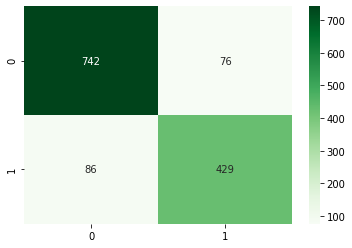

In [ ]:
THRESHOLD = 0.5

y_prediction = model_lstm.predict(x_test) > THRESHOLD
plot_confusion_matrix(y_test, y_prediction)

# Deployment

In [ ]:
model_lstm.save('lstm-128')

INFO:tensorflow:Assets written to: lstm-128/assets


INFO:tensorflow:Assets written to: lstm-128/assets


In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

## Create Cloud Storage Bucket

In [ ]:
REGION = ""
PROJECT_ID = ""
BUCKET_NAME = ""

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID gs://$BUCKET_NAME

## Upload Model to Cloud Storage

In [ ]:
! gsutil -m cp -r ./lstm-128 gs://$BUCKET_NAME

Copying file:///content/lstm-128/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/lstm-128/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file:///content/lstm-128/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///content/lstm-128/assets/tokens.txt [Content-Type=text/plain]...
Copying file:///content/lstm-128/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help 

## Create AI Platform Model 

In [ ]:
MODEL_NAME = ""

In [ ]:
! gcloud ai-platform models create $MODEL_NAME \
    --region=$REGION \
    --project=$PROJECT_ID

## Create Model Version

In [ ]:
MODEL_DIR = "gs://{}/lstm-128/".format(BUCKET_NAME)
VERSION_NAME = ""
MACHINE_TYPE = ""

In [ ]:
! gcloud ai-platform versions create $VERSION_NAME \
  --model=$MODEL_NAME \
  --origin=$MODEL_DIR \
  --runtime-version=2.4 \
  --framework=tensorflow \
  --python-version=3.7 \
  --region=$REGION \
  --machine-type=$MACHINE_TYPE \
  --project=$PROJECT_ID

## Send Prediction Request

In [ ]:
import json

input = {"instances": 
         [
          "tanggal 1 juni diperingati sebagai hari pancasila.",
          "lama kali kau datang anjeng, dari mana aja kau?"
        ]}

with open('data.json', 'w') as outfile:
    json.dump(input, outfile)

In [ ]:
! gcloud ai-platform predict \
    --project=$PROJECT_ID \
    --model=$MODEL_NAME \
    --version=$VERSION_NAME \
    --json-request=data.json \
    --region=$REGION

Contoh Output:

```
Using endpoint [https://asia-southeast1-ml.googleapis.com/]
[[8.1779981e-05], [0.810448825]]
```